In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from model import UNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# load model and set to eval mode
model = UNet(n_channels=4, n_classes=1)
model.load_state_dict(torch.load("../ckpt/0.8142160177230835_1729589887.964992.pth"))
model.to(device=device, memory_format=torch.channels_last)
model.eval()
"ok"

C:\Users\EnricLiu\AppData\Local\Temp\ipykernel_14104\565484761.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../ckpt/0.81421601772308

'ok'

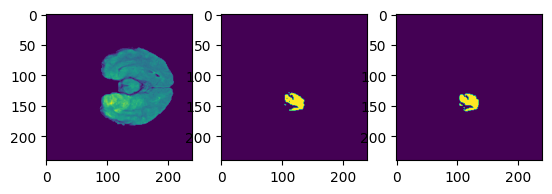

In [64]:
from datasets import get_data_path, load_data
THRESHOLD = 0.7
IMG_TYPE = ("flair", "t1", "t1ce", "t2")
DATA_DIR = "./datasets/BraTS2021_Training_Data"
PATH_ID = 100
KEY_FRAME = 50
# get test input & output
paths = get_data_path(Path(DATA_DIR))
images = load_data(paths[PATH_ID], "img", KEY_FRAME)
true_mask = load_data(paths[PATH_ID], "mask", KEY_FRAME)
# glance at the input & true mask
ax = plt.subplot(1, 3, 1)
ax.imshow(images[0])
ax = plt.subplot(1, 3, 2)
ax.imshow(true_mask)
# preprocessing image into torch Tensor
images = np.asarray([images])
images = torch.as_tensor(images.copy()).float().contiguous()
images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
# inference
res = model(images)
pred_mask = res.cpu().squeeze().detach().numpy()
# # normalization
pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
pred_mask = pred_mask > (THRESHOLD * pred_mask.max())
ax = plt.subplot(1, 3, 3)
ax.imshow(pred_mask.astype(np.uint8))
plt.show()